# K-Nearest Neighbors Homework Solutions
***
**Name**: $<$Sayali Sonawane$>$ 
***

This assignment is due on Moodle by **5pm on Friday January 26th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

<br>

![Samples of Handwritten Digits](wide_mnist.png "MNIST Digits")


<br>

This homework is designed to be pretty easy. If you're spending a ton of time on this assignment, then you are either:

- not prepared to take this course (i.e., if you're struggling with Python)
- seriously over-thinking the assignment
- trying to implement too much of KNN from scratch


Most of this assignment will be done by calling libraries that are already implemented for you. If you are implementing $n$-dimensional search or your own distance metrics, you are generating extra work for yourself and making yourself vulnerable to errors. 

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import operator
import random
%matplotlib inline 

### [5 points] Problem 1
***

The class below will load and store the MNIST data.  Load the data and then report: 
- The number of examples in the training set 
- The number of examples in the test set 
- The number of pixels in each image. 

In [2]:
class Numbers:
    """
    Class to store MNIST data
    """
    def __init__(self, location):

        import pickle, gzip

        # load data from file 
        f = gzip.open(location, 'rb')
        train_set, valid_set, test_set = pickle.load(f)
        f.close()

        # store for use later  
        self.train_x, self.train_y = train_set
        self.test_x, self.test_y = valid_set

In [3]:
#reads data
data = Numbers("../data/mnist.pklz")
#printing number of training, test examples and length of one example
print(len(data.train_x))
print(len(data.test_x))
print(len(data.test_x[0]))

50000
10000
784


### [30 points] Problem 2
***

The class below will perform K-Nearest Neighbor classification on our handwritten digit data. Your tasks are as follows:   

1. Modify the `label_counts` function to return a dictionary of frequencies corresponding to each label in the training set. 
1. Modify the `majority` function so that it returns the _label_ that appears most frequently in the $K$-nearest neighbors of the query point.  In the case that the maximum frequency occurs for two or more labels, return the one that appears most frequently in the entire training set. In the case that there is still a tie, break the tie in any way that you choose. 
1. Modify the `classify` function so that it finds the _indices_ of the $K$ closest training examples to the query point and then calls the `majority` function to return the predicted label. Almost all of the heavy lifting here will be done by the BallTree object from `sklearn.neighbors`, so you'll want to start out by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).  
1. Modify the `confusion_matrix` function to classify examples and record the results in a confusion matrix. You should construct the confusion matrix on your own.  Don't call any additional functions from sklearn to do it for you.

The class Knearest also implements an `accuracy` function which you will use in **Problem 3**.  You should not have to modify this function. 

We've given you unit tests down below based on the simple example worked out in lecture.  At first your code will fail all of them.  Do not move on to **Problem 3** until your code passes all of the unit tests. In addition, passing the unit tests does not guarantee that your implementation is robust and that you'll earn full points on this problem.  You should be designing your own additional tests as well. 

In [10]:
class Knearest:
    """
    kNN classifier
    """

    def __init__(self, X, y, k=5):
        """
        Creates a kNN instance

        :param x: Training data input
        :param y: Training data output
        :param k: The number of nearest points to consider in classification
        """

        from sklearn.neighbors import BallTree

        self._kdtree = BallTree(X)
        self._y = y
        self._k = k
        self._counts = self.label_counts()

    def label_counts(self):
        """
        Given the training labels, return a dictionary d where d[y] is
        the number of times that label y appears in the training set.
        """
        # counting number of labels in entire data set
        outdict = dict({1: 0, -1: 0})
        for i in self._y:
            if i == 1:
                outdict[1] += 1
            elif i == -1:
                outdict[-1] += 1
        return outdict

    def majority(self, neighbor_indices):
        """
        Given the indices of training examples, return the majority label. Break ties
        by choosing the tied label that appears most often in the training data.

        :param neighbor_indices: The indices of the k nearest neighbors
        """
        assert len(neighbor_indices) == self._k, "Did not get k neighbor indices"
        labels = list()
        # read the neightboring indices 
        for i in neighbor_indices:
            labels.append(self._y[i])
        countdict = {}
        
        # create dictionary to keep the counts for the labels
        for i in labels:
            countdict[i] = 0
        for i in labels:
            countdict[i] += 1
        # if only one label is observed return that label
        if len(countdict) == 1:
            return labels[0]
        else:
            # check for the max no. labels
            maxcount = 0
            out = list()
            for key, value in countdict.items():
                # if one label is in majority then return that label
                if value > len(countdict) / 2:
                    return key
                # if more labels have equal and maximum count then create a list 'out'
                if maxcount < value:
                    out.clear()
                    maxcount = value
                    out.append(key)
                elif maxcount == value:
                    out.append(key)
            labelcount = {}
            # from list 'out' check for the label which occurs more frequently than other
            for i in out:
                labelcount[i] = 0
            for i in out:
                for j in self._y:
                    if i == j:
                        labelcount[i] += 1
            maxval = 0
            selectedind = 0
            # selectind takes in the value of the label occurs for more number of times than others in training data
            # if tie occurs here as well, then take the first label that comes in the list and return that label
            for key, value in labelcount.items():
                if value > maxval:
                    maxval = value
                    selectedind = key
            return selectedind

    def classify(self, example):
        """
        Given an example, return the predicted label.

        :param example: A representation of an example in the same
        format as a row of the training data
        """
        # indices of neightboring numbers are found for the given example
        dist, ind = self._kdtree.query(example.reshape(1, -1), self._k)
        # majority function is called for those indices
        return self.majority(ind[0])

    def confusion_matrix(self, test_x, test_y):
        """
        Given a matrix of test examples and labels, compute the confusion
        matrix for the current classifier.  Should return a 2-dimensional
        numpy array of ints, C, where C[ii,jj] is the number of times an
        example with true label ii was labeled as jj.

        :param test_x: test data
        :param test_y: true test labels
        """
        # confusion matrix is formed such that columns contain the expected output
        # and rows give the calculated output
        C = np.zeros((10,10), dtype=int)
        indcount = 0
        for xx, yy in zip(test_x, test_y):
            outx = self.classify(xx)
            C[outx,yy] += 1
            if outx != yy:
                print("index of "+str(yy)+" is classified as "+str(outx)+". Index is "+str(indcount))
            indcount += 1
        return C

    @staticmethod
    def accuracy(C):
        """
        Given a confusion matrix C, compute the accuracy of the underlying classifier.

        :param C: a confusion matrix
        """

        return np.sum(C.diagonal()) / C.sum()
        

Here are the unit tests.  You don't need to modify them.  Simply execute the cell and observe the output. 

In [11]:
import unittest

class TestKnn(unittest.TestCase):
    def setUp(self):
        self.x = np.array([[2, 0], [4, 1], [6, 0], [1, 4], [2, 4], [2, 5], [4, 4], [0, 2], [3, 2], [4, 2], [5, 2], [5, 5]])
        self.y = np.array([+1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1])
        self.knn = {}
        for ii in [1, 2, 3]:
            self.knn[ii] = Knearest(self.x, self.y, ii)

        self.queries = np.array([[1, 5], [0, 3], [6, 4]])
        
    def test0(self):
        """
        Test the label counter 
        """
        self.assertEqual(self.knn[1]._counts[-1], 5)
        self.assertEqual(self.knn[1]._counts[1], 7)

    def test1(self):
        """
        Test 1NN
        """
        self.assertEqual(self.knn[1].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[1].classify(self.queries[1]), -1)
        self.assertEqual(self.knn[1].classify(self.queries[2]), -1)

    def test2(self):
        """
        Test 2NN
        """
        self.assertEqual(self.knn[2].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[2].classify(self.queries[2]),  1)

    def test3(self):
        """
        Test 3NN
        """
        self.assertEqual(self.knn[3].classify(self.queries[0]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[1]),  1)
        self.assertEqual(self.knn[3].classify(self.queries[2]), -1)
        
tests = TestKnn()
tests_to_run = unittest.TestLoader().loadTestsFromModule(tests)
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.008s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### [15 points] Problem 3
***

In this problem you'll explore the performance of the classifier you've written.  A word of advice: don't use the entire training set, especially at first.  We'll be using this dataset again later on with techniques that scale better.    

**Part A**: Explore the relationship between the number of training examples and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

index of 8 is classified as 1. Index is 8
index of 5 is classified as 6. Index is 10
index of 4 is classified as 9. Index is 22
index of 4 is classified as 9. Index is 31
index of 8 is classified as 9. Index is 44
index of 7 is classified as 9. Index is 47
index of 8 is classified as 5. Index is 48
index of 4 is classified as 1. Index is 49
index of 7 is classified as 9. Index is 64
index of 8 is classified as 9. Index is 74
index of 9 is classified as 3. Index is 78
index of 2 is classified as 7. Index is 85
index of 3 is classified as 8. Index is 87
index of 4 is classified as 9. Index is 90
index of 2 is classified as 1. Index is 105
index of 8 is classified as 2. Index is 106
index of 8 is classified as 1. Index is 114
index of 8 is classified as 3. Index is 116
index of 1 is classified as 4. Index is 120
index of 8 is classified as 3. Index is 133
index of 9 is classified as 4. Index is 144
index of 2 is classified as 1. Index is 153
index of 8 is classified as 7. Index is 170
ind

index of 2 is classified as 4. Index is 1256
index of 5 is classified as 3. Index is 1258
index of 2 is classified as 5. Index is 1262
index of 8 is classified as 1. Index is 1266
index of 3 is classified as 5. Index is 1268
index of 8 is classified as 9. Index is 1272
index of 3 is classified as 5. Index is 1274
index of 9 is classified as 1. Index is 1280
index of 9 is classified as 4. Index is 1284
index of 5 is classified as 1. Index is 1298
index of 7 is classified as 1. Index is 1300
index of 8 is classified as 1. Index is 1302
index of 8 is classified as 1. Index is 1315
index of 2 is classified as 1. Index is 1320
index of 7 is classified as 1. Index is 1322
index of 8 is classified as 5. Index is 1324
index of 8 is classified as 3. Index is 1330
index of 3 is classified as 8. Index is 1333
index of 4 is classified as 1. Index is 1337
index of 4 is classified as 9. Index is 1338
index of 2 is classified as 1. Index is 1340
index of 7 is classified as 9. Index is 1346
index of 6

index of 4 is classified as 9. Index is 2522
index of 7 is classified as 9. Index is 2525
index of 6 is classified as 0. Index is 2544
index of 2 is classified as 1. Index is 2548
index of 2 is classified as 8. Index is 2550
index of 4 is classified as 9. Index is 2580
index of 2 is classified as 1. Index is 2582
index of 7 is classified as 1. Index is 2594
index of 0 is classified as 2. Index is 2596
index of 4 is classified as 9. Index is 2600
index of 5 is classified as 9. Index is 2608
index of 5 is classified as 1. Index is 2610
index of 8 is classified as 9. Index is 2632
index of 7 is classified as 1. Index is 2644
index of 8 is classified as 1. Index is 2662
index of 7 is classified as 3. Index is 2666
index of 8 is classified as 1. Index is 2671
index of 6 is classified as 0. Index is 2674
index of 6 is classified as 1. Index is 2678
index of 5 is classified as 1. Index is 2683
index of 5 is classified as 9. Index is 2686
index of 7 is classified as 9. Index is 2707
index of 3

index of 8 is classified as 9. Index is 3806
index of 4 is classified as 9. Index is 3808
index of 5 is classified as 3. Index is 3826
index of 6 is classified as 1. Index is 3828
index of 9 is classified as 4. Index is 3831
index of 7 is classified as 1. Index is 3832
index of 3 is classified as 5. Index is 3838
index of 5 is classified as 0. Index is 3844
index of 8 is classified as 9. Index is 3848
index of 7 is classified as 9. Index is 3852
index of 9 is classified as 4. Index is 3853
index of 4 is classified as 9. Index is 3856
index of 7 is classified as 4. Index is 3858
index of 3 is classified as 5. Index is 3863
index of 7 is classified as 1. Index is 3866
index of 8 is classified as 3. Index is 3872
index of 4 is classified as 9. Index is 3873
index of 4 is classified as 9. Index is 3883
index of 2 is classified as 7. Index is 3890
index of 6 is classified as 8. Index is 3900
index of 6 is classified as 0. Index is 3909
index of 2 is classified as 1. Index is 3910
index of 4

index of 7 is classified as 9. Index is 5082
index of 7 is classified as 9. Index is 5084
index of 9 is classified as 4. Index is 5102
index of 3 is classified as 5. Index is 5103
index of 5 is classified as 9. Index is 5108
index of 3 is classified as 1. Index is 5116
index of 8 is classified as 9. Index is 5118
index of 4 is classified as 9. Index is 5124
index of 8 is classified as 0. Index is 5128
index of 2 is classified as 1. Index is 5129
index of 8 is classified as 9. Index is 5132
index of 8 is classified as 1. Index is 5146
index of 5 is classified as 9. Index is 5148
index of 8 is classified as 7. Index is 5153
index of 8 is classified as 5. Index is 5156
index of 2 is classified as 7. Index is 5170
index of 2 is classified as 7. Index is 5172
index of 3 is classified as 9. Index is 5179
index of 5 is classified as 9. Index is 5184
index of 2 is classified as 5. Index is 5188
index of 3 is classified as 1. Index is 5190
index of 3 is classified as 2. Index is 5194
index of 4

index of 7 is classified as 9. Index is 6329
index of 2 is classified as 4. Index is 6340
index of 7 is classified as 9. Index is 6346
index of 0 is classified as 6. Index is 6347
index of 0 is classified as 9. Index is 6352
index of 5 is classified as 9. Index is 6366
index of 4 is classified as 1. Index is 6379
index of 7 is classified as 9. Index is 6381
index of 8 is classified as 9. Index is 6387
index of 7 is classified as 1. Index is 6392
index of 0 is classified as 1. Index is 6397
index of 4 is classified as 9. Index is 6400
index of 5 is classified as 8. Index is 6407
index of 8 is classified as 9. Index is 6409
index of 8 is classified as 1. Index is 6412
index of 9 is classified as 7. Index is 6414
index of 2 is classified as 4. Index is 6427
index of 5 is classified as 6. Index is 6433
index of 4 is classified as 1. Index is 6452
index of 3 is classified as 9. Index is 6457
index of 0 is classified as 9. Index is 6460
index of 9 is classified as 3. Index is 6464
index of 5

index of 9 is classified as 4. Index is 7880
index of 2 is classified as 7. Index is 7894
index of 9 is classified as 4. Index is 7896
index of 8 is classified as 5. Index is 7898
index of 7 is classified as 9. Index is 7905
index of 2 is classified as 7. Index is 7911
index of 8 is classified as 9. Index is 7922
index of 7 is classified as 9. Index is 7925
index of 2 is classified as 7. Index is 7933
index of 4 is classified as 9. Index is 7940
index of 6 is classified as 4. Index is 7945
index of 7 is classified as 9. Index is 7949
index of 4 is classified as 9. Index is 7950
index of 2 is classified as 0. Index is 7953
index of 6 is classified as 1. Index is 7954
index of 8 is classified as 9. Index is 7955
index of 2 is classified as 1. Index is 7956
index of 4 is classified as 9. Index is 7965
index of 2 is classified as 7. Index is 7976
index of 5 is classified as 3. Index is 7982
index of 8 is classified as 5. Index is 7984
index of 6 is classified as 0. Index is 7994
index of 0

index of 4 is classified as 7. Index is 9915
index of 0 is classified as 5. Index is 9918
index of 6 is classified as 5. Index is 9928
index of 3 is classified as 9. Index is 9930
index of 0 is classified as 4. Index is 9934
index of 9 is classified as 7. Index is 9939
index of 4 is classified as 1. Index is 9941
index of 6 is classified as 5. Index is 9982
index of 8 is classified as 9. Index is 9999
index of 5 is classified as 7. Index is 6
index of 4 is classified as 9. Index is 14
index of 4 is classified as 9. Index is 22
index of 4 is classified as 1. Index is 49
index of 9 is classified as 4. Index is 53
index of 6 is classified as 4. Index is 59
index of 8 is classified as 1. Index is 74
index of 9 is classified as 8. Index is 78
index of 2 is classified as 7. Index is 85
index of 3 is classified as 8. Index is 87
index of 9 is classified as 7. Index is 99
index of 8 is classified as 3. Index is 114
index of 8 is classified as 3. Index is 116
index of 1 is classified as 4. Inde

index of 7 is classified as 9. Index is 1502
index of 3 is classified as 7. Index is 1522
index of 5 is classified as 7. Index is 1524
index of 7 is classified as 1. Index is 1526
index of 2 is classified as 1. Index is 1530
index of 1 is classified as 3. Index is 1544
index of 8 is classified as 6. Index is 1576
index of 2 is classified as 1. Index is 1580
index of 5 is classified as 8. Index is 1674
index of 2 is classified as 1. Index is 1682
index of 2 is classified as 7. Index is 1698
index of 9 is classified as 7. Index is 1708
index of 8 is classified as 1. Index is 1720
index of 9 is classified as 4. Index is 1730
index of 5 is classified as 6. Index is 1736
index of 5 is classified as 1. Index is 1740
index of 3 is classified as 9. Index is 1759
index of 5 is classified as 4. Index is 1764
index of 9 is classified as 7. Index is 1770
index of 4 is classified as 9. Index is 1780
index of 3 is classified as 1. Index is 1790
index of 5 is classified as 9. Index is 1794
index of 5

index of 8 is classified as 9. Index is 3181
index of 3 is classified as 5. Index is 3182
index of 8 is classified as 9. Index is 3191
index of 9 is classified as 0. Index is 3216
index of 5 is classified as 9. Index is 3244
index of 3 is classified as 8. Index is 3246
index of 8 is classified as 9. Index is 3248
index of 4 is classified as 9. Index is 3254
index of 2 is classified as 7. Index is 3264
index of 4 is classified as 1. Index is 3278
index of 9 is classified as 4. Index is 3280
index of 9 is classified as 4. Index is 3324
index of 0 is classified as 6. Index is 3344
index of 9 is classified as 7. Index is 3370
index of 2 is classified as 7. Index is 3377
index of 0 is classified as 6. Index is 3399
index of 8 is classified as 2. Index is 3420
index of 5 is classified as 9. Index is 3433
index of 4 is classified as 9. Index is 3439
index of 5 is classified as 9. Index is 3461
index of 8 is classified as 9. Index is 3462
index of 5 is classified as 1. Index is 3470
index of 4

index of 8 is classified as 9. Index is 4916
index of 7 is classified as 1. Index is 4917
index of 8 is classified as 1. Index is 4926
index of 5 is classified as 4. Index is 4928
index of 5 is classified as 6. Index is 4932
index of 8 is classified as 6. Index is 4935
index of 5 is classified as 1. Index is 4949
index of 8 is classified as 7. Index is 4950
index of 8 is classified as 2. Index is 4954
index of 7 is classified as 9. Index is 4957
index of 8 is classified as 9. Index is 4958
index of 7 is classified as 9. Index is 4971
index of 5 is classified as 1. Index is 4975
index of 3 is classified as 2. Index is 4977
index of 2 is classified as 4. Index is 4981
index of 3 is classified as 5. Index is 4983
index of 4 is classified as 9. Index is 4998
index of 8 is classified as 9. Index is 5015
index of 8 is classified as 1. Index is 5022
index of 3 is classified as 0. Index is 5028
index of 2 is classified as 7. Index is 5040
index of 5 is classified as 4. Index is 5042
index of 3

index of 4 is classified as 9. Index is 6723
index of 9 is classified as 4. Index is 6742
index of 9 is classified as 7. Index is 6773
index of 9 is classified as 7. Index is 6792
index of 4 is classified as 9. Index is 6799
index of 9 is classified as 3. Index is 6800
index of 4 is classified as 6. Index is 6802
index of 5 is classified as 0. Index is 6804
index of 2 is classified as 8. Index is 6824
index of 4 is classified as 9. Index is 6826
index of 5 is classified as 3. Index is 6838
index of 8 is classified as 1. Index is 6842
index of 2 is classified as 1. Index is 6864
index of 8 is classified as 7. Index is 6874
index of 2 is classified as 5. Index is 6876
index of 5 is classified as 3. Index is 6890
index of 0 is classified as 7. Index is 6914
index of 2 is classified as 3. Index is 6922
index of 5 is classified as 7. Index is 6939
index of 5 is classified as 6. Index is 6962
index of 5 is classified as 4. Index is 6990
index of 3 is classified as 5. Index is 6995
index of 2

index of 8 is classified as 1. Index is 8709
index of 8 is classified as 1. Index is 8748
index of 9 is classified as 4. Index is 8792
index of 3 is classified as 2. Index is 8812
index of 3 is classified as 7. Index is 8832
index of 5 is classified as 6. Index is 8871
index of 3 is classified as 8. Index is 8892
index of 8 is classified as 3. Index is 8915
index of 5 is classified as 3. Index is 8930
index of 9 is classified as 7. Index is 8961
index of 4 is classified as 9. Index is 8994
index of 4 is classified as 9. Index is 9020
index of 7 is classified as 9. Index is 9056
index of 7 is classified as 9. Index is 9083
index of 2 is classified as 7. Index is 9113
index of 8 is classified as 7. Index is 9128
index of 4 is classified as 9. Index is 9139
index of 3 is classified as 2. Index is 9158
index of 5 is classified as 0. Index is 9196
index of 8 is classified as 5. Index is 9286
index of 2 is classified as 7. Index is 9290
index of 5 is classified as 9. Index is 9291
index of 8

index of 4 is classified as 9. Index is 1077
index of 2 is classified as 1. Index is 1100
index of 7 is classified as 2. Index is 1102
index of 8 is classified as 1. Index is 1104
index of 4 is classified as 9. Index is 1111
index of 4 is classified as 9. Index is 1125
index of 5 is classified as 9. Index is 1144
index of 0 is classified as 6. Index is 1148
index of 8 is classified as 6. Index is 1158
index of 8 is classified as 9. Index is 1164
index of 8 is classified as 1. Index is 1172
index of 7 is classified as 4. Index is 1174
index of 7 is classified as 4. Index is 1180
index of 9 is classified as 4. Index is 1192
index of 9 is classified as 3. Index is 1194
index of 9 is classified as 1. Index is 1200
index of 5 is classified as 9. Index is 1234
index of 9 is classified as 4. Index is 1248
index of 2 is classified as 3. Index is 1256
index of 2 is classified as 7. Index is 1262
index of 8 is classified as 1. Index is 1266
index of 9 is classified as 1. Index is 1280
index of 5

index of 5 is classified as 6. Index is 3015
index of 2 is classified as 9. Index is 3017
index of 2 is classified as 7. Index is 3019
index of 2 is classified as 7. Index is 3029
index of 2 is classified as 7. Index is 3033
index of 8 is classified as 7. Index is 3036
index of 9 is classified as 3. Index is 3044
index of 4 is classified as 9. Index is 3052
index of 5 is classified as 6. Index is 3063
index of 3 is classified as 9. Index is 3075
index of 2 is classified as 7. Index is 3076
index of 7 is classified as 9. Index is 3113
index of 6 is classified as 1. Index is 3148
index of 3 is classified as 7. Index is 3156
index of 8 is classified as 9. Index is 3170
index of 8 is classified as 9. Index is 3181
index of 9 is classified as 0. Index is 3216
index of 8 is classified as 9. Index is 3248
index of 4 is classified as 9. Index is 3254
index of 4 is classified as 1. Index is 3278
index of 5 is classified as 3. Index is 3296
index of 0 is classified as 6. Index is 3344
index of 9

index of 8 is classified as 1. Index is 5022
index of 3 is classified as 0. Index is 5028
index of 5 is classified as 4. Index is 5042
index of 7 is classified as 1. Index is 5052
index of 3 is classified as 5. Index is 5054
index of 5 is classified as 3. Index is 5060
index of 3 is classified as 1. Index is 5116
index of 8 is classified as 0. Index is 5128
index of 8 is classified as 7. Index is 5153
index of 8 is classified as 5. Index is 5156
index of 2 is classified as 5. Index is 5188
index of 3 is classified as 2. Index is 5194
index of 8 is classified as 1. Index is 5264
index of 0 is classified as 2. Index is 5278
index of 2 is classified as 7. Index is 5281
index of 4 is classified as 9. Index is 5294
index of 9 is classified as 1. Index is 5296
index of 2 is classified as 1. Index is 5304
index of 1 is classified as 7. Index is 5310
index of 2 is classified as 1. Index is 5319
index of 4 is classified as 6. Index is 5320
index of 5 is classified as 3. Index is 5322
index of 8

index of 7 is classified as 9. Index is 7367
index of 7 is classified as 4. Index is 7380
index of 3 is classified as 5. Index is 7396
index of 2 is classified as 1. Index is 7398
index of 8 is classified as 9. Index is 7450
index of 3 is classified as 8. Index is 7472
index of 3 is classified as 9. Index is 7477
index of 5 is classified as 9. Index is 7480
index of 7 is classified as 9. Index is 7485
index of 5 is classified as 3. Index is 7510
index of 3 is classified as 8. Index is 7523
index of 2 is classified as 7. Index is 7574
index of 3 is classified as 5. Index is 7598
index of 5 is classified as 9. Index is 7610
index of 8 is classified as 1. Index is 7618
index of 2 is classified as 8. Index is 7624
index of 2 is classified as 0. Index is 7628
index of 4 is classified as 9. Index is 7630
index of 7 is classified as 9. Index is 7643
index of 5 is classified as 6. Index is 7662
index of 7 is classified as 9. Index is 7663
index of 8 is classified as 1. Index is 7665
index of 9

index of 6 is classified as 0. Index is 294
index of 3 is classified as 8. Index is 297
index of 8 is classified as 3. Index is 306
index of 8 is classified as 2. Index is 307
index of 3 is classified as 2. Index is 317
index of 5 is classified as 7. Index is 320
index of 9 is classified as 7. Index is 329
index of 3 is classified as 2. Index is 340
index of 8 is classified as 0. Index is 342
index of 9 is classified as 7. Index is 349
index of 7 is classified as 1. Index is 359
index of 8 is classified as 1. Index is 363
index of 5 is classified as 9. Index is 366
index of 2 is classified as 1. Index is 368
index of 3 is classified as 9. Index is 369
index of 7 is classified as 4. Index is 370
index of 7 is classified as 9. Index is 371
index of 9 is classified as 4. Index is 391
index of 8 is classified as 1. Index is 393
index of 3 is classified as 9. Index is 403
index of 8 is classified as 1. Index is 413
index of 9 is classified as 3. Index is 414
index of 3 is classified as 8. I

index of 2 is classified as 7. Index is 2316
index of 2 is classified as 4. Index is 2319
index of 9 is classified as 7. Index is 2324
index of 5 is classified as 3. Index is 2347
index of 2 is classified as 7. Index is 2358
index of 9 is classified as 4. Index is 2372
index of 8 is classified as 3. Index is 2390
index of 1 is classified as 2. Index is 2392
index of 3 is classified as 5. Index is 2394
index of 4 is classified as 9. Index is 2402
index of 2 is classified as 1. Index is 2422
index of 4 is classified as 9. Index is 2424
index of 5 is classified as 6. Index is 2452
index of 2 is classified as 1. Index is 2456
index of 7 is classified as 1. Index is 2460
index of 8 is classified as 3. Index is 2465
index of 7 is classified as 9. Index is 2477
index of 9 is classified as 3. Index is 2478
index of 8 is classified as 9. Index is 2483
index of 9 is classified as 4. Index is 2510
index of 4 is classified as 9. Index is 2522
index of 2 is classified as 1. Index is 2548
index of 2

index of 8 is classified as 6. Index is 4492
index of 8 is classified as 9. Index is 4498
index of 1 is classified as 2. Index is 4506
index of 9 is classified as 5. Index is 4520
index of 4 is classified as 9. Index is 4521
index of 5 is classified as 3. Index is 4528
index of 7 is classified as 9. Index is 4542
index of 2 is classified as 8. Index is 4551
index of 8 is classified as 1. Index is 4554
index of 2 is classified as 6. Index is 4574
index of 8 is classified as 2. Index is 4596
index of 3 is classified as 2. Index is 4616
index of 8 is classified as 0. Index is 4624
index of 4 is classified as 1. Index is 4628
index of 4 is classified as 9. Index is 4650
index of 2 is classified as 8. Index is 4674
index of 2 is classified as 7. Index is 4682
index of 8 is classified as 7. Index is 4701
index of 3 is classified as 8. Index is 4707
index of 2 is classified as 4. Index is 4714
index of 9 is classified as 4. Index is 4738
index of 4 is classified as 9. Index is 4742
index of 5

index of 2 is classified as 1. Index is 6864
index of 8 is classified as 5. Index is 6874
index of 8 is classified as 3. Index is 6879
index of 5 is classified as 3. Index is 6890
index of 2 is classified as 3. Index is 6922
index of 5 is classified as 4. Index is 6939
index of 5 is classified as 6. Index is 6962
index of 5 is classified as 4. Index is 6990
index of 3 is classified as 4. Index is 7004
index of 8 is classified as 1. Index is 7021
index of 0 is classified as 9. Index is 7041
index of 4 is classified as 1. Index is 7043
index of 8 is classified as 7. Index is 7054
index of 4 is classified as 1. Index is 7076
index of 4 is classified as 9. Index is 7082
index of 2 is classified as 7. Index is 7086
index of 8 is classified as 9. Index is 7090
index of 5 is classified as 4. Index is 7156
index of 7 is classified as 1. Index is 7188
index of 3 is classified as 5. Index is 7195
index of 4 is classified as 1. Index is 7208
index of 5 is classified as 3. Index is 7211
index of 5

index of 6 is classified as 0. Index is 294
index of 3 is classified as 8. Index is 297
index of 8 is classified as 3. Index is 306
index of 8 is classified as 2. Index is 307
index of 5 is classified as 7. Index is 320
index of 9 is classified as 7. Index is 329
index of 3 is classified as 2. Index is 340
index of 8 is classified as 0. Index is 342
index of 9 is classified as 7. Index is 349
index of 7 is classified as 1. Index is 359
index of 8 is classified as 1. Index is 363
index of 5 is classified as 9. Index is 366
index of 2 is classified as 1. Index is 368
index of 3 is classified as 9. Index is 369
index of 7 is classified as 4. Index is 370
index of 7 is classified as 9. Index is 371
index of 9 is classified as 4. Index is 391
index of 8 is classified as 1. Index is 393
index of 3 is classified as 9. Index is 403
index of 8 is classified as 3. Index is 410
index of 8 is classified as 1. Index is 413
index of 9 is classified as 3. Index is 414
index of 3 is classified as 8. I

index of 2 is classified as 1. Index is 2456
index of 7 is classified as 1. Index is 2460
index of 8 is classified as 9. Index is 2483
index of 4 is classified as 9. Index is 2522
index of 2 is classified as 1. Index is 2548
index of 2 is classified as 6. Index is 2582
index of 3 is classified as 5. Index is 2590
index of 5 is classified as 3. Index is 2610
index of 8 is classified as 9. Index is 2632
index of 7 is classified as 1. Index is 2644
index of 8 is classified as 1. Index is 2671
index of 9 is classified as 7. Index is 2672
index of 6 is classified as 0. Index is 2674
index of 7 is classified as 1. Index is 2687
index of 7 is classified as 9. Index is 2707
index of 8 is classified as 1. Index is 2719
index of 8 is classified as 3. Index is 2722
index of 4 is classified as 6. Index is 2727
index of 1 is classified as 2. Index is 2738
index of 7 is classified as 1. Index is 2744
index of 5 is classified as 3. Index is 2792
index of 2 is classified as 1. Index is 2802
index of 8

index of 2 is classified as 6. Index is 4848
index of 3 is classified as 5. Index is 4858
index of 4 is classified as 9. Index is 4861
index of 3 is classified as 5. Index is 4879
index of 5 is classified as 6. Index is 4880
index of 5 is classified as 1. Index is 4883
index of 6 is classified as 0. Index is 4885
index of 7 is classified as 9. Index is 4891
index of 8 is classified as 9. Index is 4896
index of 8 is classified as 1. Index is 4909
index of 8 is classified as 9. Index is 4916
index of 7 is classified as 1. Index is 4917
index of 8 is classified as 1. Index is 4926
index of 5 is classified as 6. Index is 4932
index of 8 is classified as 6. Index is 4935
index of 5 is classified as 1. Index is 4949
index of 8 is classified as 7. Index is 4950
index of 8 is classified as 2. Index is 4954
index of 7 is classified as 9. Index is 4957
index of 8 is classified as 9. Index is 4958
index of 7 is classified as 9. Index is 4966
index of 5 is classified as 1. Index is 4975
index of 3

index of 3 is classified as 5. Index is 7698
index of 4 is classified as 9. Index is 7713
index of 7 is classified as 1. Index is 7718
index of 9 is classified as 5. Index is 7728
index of 9 is classified as 7. Index is 7729
index of 8 is classified as 1. Index is 7731
index of 9 is classified as 3. Index is 7732
index of 3 is classified as 5. Index is 7735
index of 4 is classified as 9. Index is 7747
index of 2 is classified as 7. Index is 7755
index of 3 is classified as 2. Index is 7766
index of 5 is classified as 0. Index is 7768
index of 2 is classified as 7. Index is 7808
index of 7 is classified as 9. Index is 7836
index of 5 is classified as 0. Index is 7837
index of 4 is classified as 9. Index is 7862
index of 3 is classified as 2. Index is 7872
index of 2 is classified as 7. Index is 7894
index of 8 is classified as 3. Index is 7898
index of 3 is classified as 5. Index is 7909
index of 4 is classified as 9. Index is 7938
index of 2 is classified as 0. Index is 7953
index of 2

index of 5 is classified as 3. Index is 881
index of 5 is classified as 3. Index is 887
index of 2 is classified as 6. Index is 897
index of 9 is classified as 5. Index is 908
index of 4 is classified as 9. Index is 917
index of 5 is classified as 8. Index is 926
index of 4 is classified as 1. Index is 981
index of 3 is classified as 5. Index is 982
index of 4 is classified as 9. Index is 1018
index of 4 is classified as 9. Index is 1049
index of 3 is classified as 7. Index is 1054
index of 6 is classified as 4. Index is 1066
index of 4 is classified as 9. Index is 1071
index of 2 is classified as 8. Index is 1073
index of 4 is classified as 9. Index is 1077
index of 2 is classified as 1. Index is 1100
index of 8 is classified as 1. Index is 1104
index of 4 is classified as 9. Index is 1125
index of 5 is classified as 6. Index is 1130
index of 5 is classified as 6. Index is 1144
index of 8 is classified as 6. Index is 1158
index of 8 is classified as 9. Index is 1164
index of 8 is clas

index of 3 is classified as 2. Index is 3570
index of 8 is classified as 6. Index is 3574
index of 6 is classified as 8. Index is 3578
index of 5 is classified as 3. Index is 3598
index of 7 is classified as 4. Index is 3612
index of 9 is classified as 7. Index is 3623
index of 8 is classified as 1. Index is 3636
index of 8 is classified as 1. Index is 3640
index of 9 is classified as 7. Index is 3645
index of 4 is classified as 9. Index is 3673
index of 4 is classified as 9. Index is 3713
index of 9 is classified as 7. Index is 3723
index of 4 is classified as 9. Index is 3731
index of 9 is classified as 1. Index is 3736
index of 4 is classified as 9. Index is 3739
index of 3 is classified as 5. Index is 3740
index of 4 is classified as 9. Index is 3767
index of 8 is classified as 9. Index is 3806
index of 7 is classified as 1. Index is 3832
index of 4 is classified as 9. Index is 3834
index of 5 is classified as 0. Index is 3844
index of 4 is classified as 9. Index is 3856
index of 4

index of 5 is classified as 4. Index is 6366
index of 4 is classified as 1. Index is 6379
index of 3 is classified as 2. Index is 6391
index of 8 is classified as 3. Index is 6412
index of 4 is classified as 1. Index is 6452
index of 3 is classified as 9. Index is 6457
index of 9 is classified as 3. Index is 6464
index of 9 is classified as 7. Index is 6480
index of 9 is classified as 4. Index is 6527
index of 5 is classified as 6. Index is 6566
index of 5 is classified as 6. Index is 6586
index of 2 is classified as 1. Index is 6590
index of 4 is classified as 9. Index is 6596
index of 8 is classified as 1. Index is 6600
index of 2 is classified as 0. Index is 6614
index of 8 is classified as 3. Index is 6628
index of 8 is classified as 3. Index is 6636
index of 3 is classified as 6. Index is 6645
index of 4 is classified as 9. Index is 6646
index of 2 is classified as 7. Index is 6655
index of 8 is classified as 1. Index is 6672
index of 9 is classified as 4. Index is 6708
index of 9

index of 3 is classified as 5. Index is 33
index of 4 is classified as 1. Index is 49
index of 8 is classified as 4. Index is 74
index of 9 is classified as 3. Index is 78
index of 8 is classified as 2. Index is 116
index of 1 is classified as 4. Index is 120
index of 4 is classified as 9. Index is 134
index of 8 is classified as 1. Index is 178
index of 8 is classified as 9. Index is 180
index of 2 is classified as 7. Index is 196
index of 3 is classified as 9. Index is 212
index of 0 is classified as 1. Index is 236
index of 9 is classified as 0. Index is 239
index of 8 is classified as 1. Index is 246
index of 0 is classified as 6. Index is 256
index of 8 is classified as 3. Index is 258
index of 8 is classified as 3. Index is 274
index of 6 is classified as 0. Index is 294
index of 8 is classified as 2. Index is 307
index of 5 is classified as 7. Index is 320
index of 5 is classified as 3. Index is 322
index of 9 is classified as 7. Index is 329
index of 3 is classified as 2. Index

index of 6 is classified as 0. Index is 2674
index of 7 is classified as 1. Index is 2687
index of 7 is classified as 9. Index is 2707
index of 8 is classified as 1. Index is 2719
index of 4 is classified as 6. Index is 2727
index of 1 is classified as 2. Index is 2738
index of 7 is classified as 1. Index is 2744
index of 9 is classified as 2. Index is 2800
index of 2 is classified as 1. Index is 2802
index of 9 is classified as 3. Index is 2814
index of 3 is classified as 7. Index is 2828
index of 2 is classified as 1. Index is 2834
index of 7 is classified as 1. Index is 2842
index of 5 is classified as 6. Index is 2857
index of 8 is classified as 9. Index is 2862
index of 2 is classified as 9. Index is 2869
index of 4 is classified as 8. Index is 2873
index of 5 is classified as 6. Index is 2875
index of 7 is classified as 9. Index is 2886
index of 2 is classified as 1. Index is 2894
index of 7 is classified as 2. Index is 2899
index of 3 is classified as 8. Index is 2907
index of 8

index of 7 is classified as 4. Index is 5244
index of 9 is classified as 7. Index is 5247
index of 8 is classified as 1. Index is 5264
index of 0 is classified as 2. Index is 5278
index of 2 is classified as 7. Index is 5281
index of 4 is classified as 9. Index is 5294
index of 8 is classified as 9. Index is 5311
index of 2 is classified as 1. Index is 5319
index of 5 is classified as 3. Index is 5322
index of 4 is classified as 1. Index is 5340
index of 2 is classified as 8. Index is 5352
index of 3 is classified as 8. Index is 5353
index of 8 is classified as 1. Index is 5368
index of 8 is classified as 1. Index is 5395
index of 5 is classified as 0. Index is 5396
index of 7 is classified as 9. Index is 5426
index of 2 is classified as 0. Index is 5429
index of 8 is classified as 4. Index is 5438
index of 9 is classified as 0. Index is 5496
index of 5 is classified as 3. Index is 5513
index of 8 is classified as 1. Index is 5530
index of 8 is classified as 1. Index is 5578
index of 8

index of 5 is classified as 9. Index is 8871
index of 3 is classified as 8. Index is 8874
index of 3 is classified as 8. Index is 8892
index of 9 is classified as 7. Index is 8961
index of 4 is classified as 9. Index is 9069
index of 7 is classified as 9. Index is 9083
index of 4 is classified as 9. Index is 9139
index of 3 is classified as 2. Index is 9158
index of 7 is classified as 9. Index is 9213
index of 8 is classified as 5. Index is 9286
index of 8 is classified as 5. Index is 9294
index of 8 is classified as 5. Index is 9303
index of 8 is classified as 0. Index is 9309
index of 9 is classified as 0. Index is 9314
index of 8 is classified as 5. Index is 9340
index of 9 is classified as 3. Index is 9344
index of 1 is classified as 8. Index is 9354
index of 8 is classified as 9. Index is 9361
index of 4 is classified as 9. Index is 9367
index of 5 is classified as 3. Index is 9368
index of 8 is classified as 3. Index is 9380
index of 5 is classified as 3. Index is 9384
index of 8

index of 7 is classified as 9. Index is 2166
index of 7 is classified as 1. Index is 2173
index of 2 is classified as 1. Index is 2189
index of 5 is classified as 4. Index is 2210
index of 8 is classified as 6. Index is 2218
index of 2 is classified as 4. Index is 2225
index of 9 is classified as 4. Index is 2236
index of 8 is classified as 9. Index is 2241
index of 0 is classified as 6. Index is 2245
index of 4 is classified as 9. Index is 2246
index of 7 is classified as 9. Index is 2261
index of 4 is classified as 1. Index is 2279
index of 8 is classified as 9. Index is 2280
index of 0 is classified as 6. Index is 2294
index of 8 is classified as 4. Index is 2306
index of 2 is classified as 7. Index is 2316
index of 2 is classified as 4. Index is 2319
index of 9 is classified as 7. Index is 2324
index of 5 is classified as 3. Index is 2347
index of 8 is classified as 3. Index is 2390
index of 1 is classified as 2. Index is 2392
index of 2 is classified as 1. Index is 2422
index of 4

index of 8 is classified as 9. Index is 4916
index of 7 is classified as 1. Index is 4917
index of 8 is classified as 9. Index is 4926
index of 5 is classified as 6. Index is 4932
index of 4 is classified as 9. Index is 4936
index of 7 is classified as 9. Index is 4937
index of 5 is classified as 1. Index is 4949
index of 8 is classified as 7. Index is 4950
index of 8 is classified as 2. Index is 4954
index of 8 is classified as 9. Index is 4958
index of 5 is classified as 1. Index is 4975
index of 3 is classified as 2. Index is 4977
index of 8 is classified as 3. Index is 4986
index of 9 is classified as 7. Index is 4993
index of 8 is classified as 9. Index is 5015
index of 3 is classified as 5. Index is 5028
index of 5 is classified as 6. Index is 5042
index of 3 is classified as 5. Index is 5054
index of 5 is classified as 3. Index is 5060
index of 8 is classified as 3. Index is 5122
index of 8 is classified as 0. Index is 5128
index of 8 is classified as 7. Index is 5153
index of 8

index of 8 is classified as 3. Index is 8384
index of 8 is classified as 2. Index is 8394
index of 9 is classified as 3. Index is 8413
index of 6 is classified as 0. Index is 8435
index of 8 is classified as 5. Index is 8445
index of 8 is classified as 9. Index is 8518
index of 8 is classified as 9. Index is 8543
index of 0 is classified as 3. Index is 8560
index of 8 is classified as 5. Index is 8593
index of 8 is classified as 9. Index is 8595
index of 7 is classified as 1. Index is 8648
index of 0 is classified as 6. Index is 8649
index of 2 is classified as 7. Index is 8651
index of 7 is classified as 9. Index is 8676
index of 5 is classified as 3. Index is 8803
index of 3 is classified as 9. Index is 8832
index of 5 is classified as 7. Index is 8871
index of 3 is classified as 8. Index is 8874
index of 3 is classified as 8. Index is 8892
index of 9 is classified as 7. Index is 8961
index of 4 is classified as 9. Index is 9069
index of 4 is classified as 9. Index is 9139
index of 3

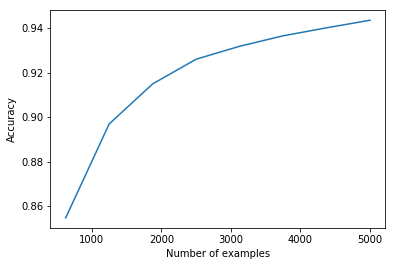

In [13]:
"""
the knn is trained over different number of examples and tested on test data
""" 
trainset = list(np.linspace(0,5000, num=9))
acc = list()
for i in trainset[1:]:
    knn = Knearest(data.train_x[0:int(i)], data.train_y[0:int(i)], 5)
    c = knn.confusion_matrix(data.test_x, data.test_y)
    acc.append(knn.accuracy(c))

# plot of accuracy of knn on test data is plotted against the number of training examples
"""
Comment on finding -
You can see the accuracy increasing with number of training samples. This happens because more the number of examples, 
better the prediction of knn. For samples 6500 the accuracy is 94.5% while for 50000  samples the accuracy is 97.5%. 
If knn is trained on more number of examples the accuracy will further increase.
"""
plt.plot(trainset[1:], acc)
plt.xlabel("Number of examples")
plt.ylabel("Accuracy")
plt.show()


**Part B**: Explore the relationship between the number of nearest neighbors and accuracy on the test set. Comment on your findings and support your observations with some kind of graphic. 

In [14]:
"""
knn is trained over 50000 examples for different k. k represents the number of examples we observe around the target example
""" 
accu = list()
for i in range(1,11):
    knn = Knearest(data.train_x, data.train_y, i)
    c = knn.confusion_matrix(data.test_x, data.test_y)
    accu.append(knn.accuracy(c))
    
# accuracy is plotted against k. 
"""
As seen from the figure accuracy falls for k = 2, then increases again. This might because when k = 2, the example might be
surrounded by different labels. We are following a such strategy to break the tie which might lead to inaccuracy 50% of the time. 
Then why the accuracy not decreasing for other even numbers? The reason being, example might be surrounded by examples with majority
of same kind of label. e.g. for k = 4, 2 or 3 might be of same label and others of different label.
The best performance is observed for odd values of k for the very reason stated above. It will not give any inaccurate prediction.

Why does the accuracy decreases for higher values of k?
Because the more number of observation you consider, your radius of observation increases and it considers the examples which are 
away from the target. If those far away labels are more in number then the classification misclassifies the example.

Maximum accuracy is observed at k = 5, because it is odd (reason given above) and it is not too small for observations to be observed
for overfitting or not too large for under fitting.

A good value of accuracy is observed for k = 1, usually that gives overfitted classification.
"""
x = [i for i in range(1,11)]
plt.plot(x,accu)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

index of 4 is classified as 9. Index is 5
index of 6 is classified as 2. Index is 86
index of 9 is classified as 4. Index is 177
index of 8 is classified as 9. Index is 180
index of 2 is classified as 7. Index is 229
index of 9 is classified as 0. Index is 239
index of 8 is classified as 3. Index is 246
index of 0 is classified as 6. Index is 256
index of 3 is classified as 5. Index is 308
index of 3 is classified as 2. Index is 317
index of 9 is classified as 7. Index is 318
index of 5 is classified as 3. Index is 322
index of 9 is classified as 7. Index is 329
index of 3 is classified as 2. Index is 340
index of 8 is classified as 5. Index is 342
index of 7 is classified as 1. Index is 359
index of 2 is classified as 3. Index is 368
index of 3 is classified as 9. Index is 369
index of 9 is classified as 4. Index is 391
index of 3 is classified as 9. Index is 403
index of 9 is classified as 3. Index is 414
index of 3 is classified as 8. Index is 417
index of 7 is classified as 1. Inde

index of 9 is classified as 3. Index is 5834
index of 3 is classified as 2. Index is 5844
index of 1 is classified as 2. Index is 5870
index of 5 is classified as 6. Index is 5886
index of 5 is classified as 6. Index is 5908
index of 9 is classified as 4. Index is 5970
index of 3 is classified as 5. Index is 5974
index of 5 is classified as 8. Index is 6014
index of 5 is classified as 9. Index is 6054
index of 7 is classified as 1. Index is 6066
index of 8 is classified as 1. Index is 6082
index of 7 is classified as 9. Index is 6220
index of 5 is classified as 3. Index is 6224
index of 3 is classified as 8. Index is 6228
index of 4 is classified as 7. Index is 6244
index of 8 is classified as 9. Index is 6254
index of 9 is classified as 7. Index is 6271
index of 5 is classified as 3. Index is 6344
index of 4 is classified as 9. Index is 6380
index of 4 is classified as 1. Index is 6452
index of 3 is classified as 5. Index is 6474
index of 9 is classified as 5. Index is 6480
index of 9

index of 5 is classified as 0. Index is 2106
index of 5 is classified as 9. Index is 2122
index of 9 is classified as 7. Index is 2127
index of 3 is classified as 5. Index is 2129
index of 9 is classified as 7. Index is 2138
index of 4 is classified as 9. Index is 2140
index of 2 is classified as 7. Index is 2144
index of 7 is classified as 1. Index is 2173
index of 5 is classified as 9. Index is 2210
index of 8 is classified as 6. Index is 2218
index of 8 is classified as 4. Index is 2219
index of 4 is classified as 9. Index is 2246
index of 4 is classified as 1. Index is 2279
index of 8 is classified as 9. Index is 2280
index of 0 is classified as 6. Index is 2294
index of 2 is classified as 7. Index is 2316
index of 9 is classified as 7. Index is 2324
index of 5 is classified as 3. Index is 2326
index of 5 is classified as 3. Index is 2347
index of 5 is classified as 8. Index is 2388
index of 4 is classified as 9. Index is 2414
index of 2 is classified as 1. Index is 2422
index of 4

index of 5 is classified as 6. Index is 6732
index of 9 is classified as 7. Index is 6773
index of 9 is classified as 3. Index is 6800
index of 5 is classified as 3. Index is 6812
index of 2 is classified as 7. Index is 6824
index of 8 is classified as 7. Index is 6842
index of 0 is classified as 9. Index is 6914
index of 5 is classified as 6. Index is 6962
index of 8 is classified as 3. Index is 6976
index of 9 is classified as 7. Index is 7018
index of 8 is classified as 1. Index is 7021
index of 0 is classified as 9. Index is 7041
index of 8 is classified as 7. Index is 7054
index of 4 is classified as 1. Index is 7076
index of 4 is classified as 9. Index is 7082
index of 8 is classified as 9. Index is 7084
index of 5 is classified as 6. Index is 7256
index of 2 is classified as 3. Index is 7262
index of 8 is classified as 3. Index is 7276
index of 9 is classified as 4. Index is 7290
index of 5 is classified as 6. Index is 7302
index of 5 is classified as 7. Index is 7462
index of 5

index of 8 is classified as 3. Index is 2932
index of 2 is classified as 7. Index is 2938
index of 2 is classified as 8. Index is 2953
index of 8 is classified as 7. Index is 2968
index of 2 is classified as 7. Index is 2971
index of 2 is classified as 7. Index is 2975
index of 5 is classified as 6. Index is 2981
index of 5 is classified as 6. Index is 3015
index of 2 is classified as 7. Index is 3017
index of 2 is classified as 7. Index is 3029
index of 9 is classified as 3. Index is 3044
index of 5 is classified as 6. Index is 3063
index of 5 is classified as 6. Index is 3069
index of 2 is classified as 7. Index is 3076
index of 3 is classified as 2. Index is 3156
index of 8 is classified as 5. Index is 3181
index of 9 is classified as 0. Index is 3216
index of 8 is classified as 9. Index is 3248
index of 5 is classified as 3. Index is 3306
index of 8 is classified as 5. Index is 3312
index of 9 is classified as 4. Index is 3396
index of 5 is classified as 7. Index is 3470
index of 4

index of 0 is classified as 9. Index is 9653
index of 0 is classified as 2. Index is 9681
index of 5 is classified as 6. Index is 9701
index of 8 is classified as 5. Index is 9718
index of 9 is classified as 5. Index is 9719
index of 2 is classified as 0. Index is 9720
index of 5 is classified as 3. Index is 9726
index of 5 is classified as 6. Index is 9731
index of 5 is classified as 3. Index is 9747
index of 4 is classified as 1. Index is 9766
index of 4 is classified as 7. Index is 9915
index of 4 is classified as 9. Index is 5
index of 9 is classified as 7. Index is 88
index of 1 is classified as 4. Index is 120
index of 2 is classified as 7. Index is 229
index of 9 is classified as 0. Index is 239
index of 5 is classified as 7. Index is 320
index of 9 is classified as 7. Index is 329
index of 3 is classified as 2. Index is 340
index of 8 is classified as 5. Index is 342
index of 7 is classified as 1. Index is 359
index of 2 is classified as 1. Index is 368
index of 3 is classified

index of 2 is classified as 5. Index is 5906
index of 5 is classified as 6. Index is 5908
index of 9 is classified as 4. Index is 5970
index of 3 is classified as 5. Index is 5974
index of 5 is classified as 3. Index is 6014
index of 5 is classified as 9. Index is 6054
index of 7 is classified as 1. Index is 6066
index of 8 is classified as 1. Index is 6082
index of 7 is classified as 9. Index is 6220
index of 5 is classified as 3. Index is 6224
index of 3 is classified as 8. Index is 6228
index of 8 is classified as 9. Index is 6254
index of 9 is classified as 1. Index is 6271
index of 9 is classified as 1. Index is 6292
index of 4 is classified as 9. Index is 6380
index of 4 is classified as 1. Index is 6452
index of 3 is classified as 5. Index is 6474
index of 9 is classified as 5. Index is 6480
index of 0 is classified as 6. Index is 6573
index of 5 is classified as 6. Index is 6586
index of 2 is classified as 1. Index is 6590
index of 4 is classified as 9. Index is 6596
index of 2

index of 4 is classified as 7. Index is 3476
index of 2 is classified as 0. Index is 3522
index of 3 is classified as 7. Index is 3547
index of 8 is classified as 3. Index is 3556
index of 3 is classified as 7. Index is 3570
index of 6 is classified as 5. Index is 3578
index of 7 is classified as 9. Index is 3612
index of 9 is classified as 7. Index is 3623
index of 9 is classified as 1. Index is 3736
index of 2 is classified as 3. Index is 3762
index of 8 is classified as 9. Index is 3806
index of 7 is classified as 9. Index is 3852
index of 3 is classified as 5. Index is 3975
index of 5 is classified as 6. Index is 3978
index of 8 is classified as 3. Index is 3979
index of 8 is classified as 2. Index is 3996
index of 8 is classified as 3. Index is 3997
index of 8 is classified as 0. Index is 3999
index of 5 is classified as 8. Index is 4002
index of 3 is classified as 5. Index is 4074
index of 7 is classified as 9. Index is 4097
index of 8 is classified as 3. Index is 4195
index of 4

index of 5 is classified as 3. Index is 895
index of 4 is classified as 9. Index is 917
index of 8 is classified as 5. Index is 1094
index of 4 is classified as 9. Index is 1125
index of 9 is classified as 3. Index is 1194
index of 9 is classified as 4. Index is 1248
index of 7 is classified as 1. Index is 1300
index of 8 is classified as 1. Index is 1315
index of 0 is classified as 2. Index is 1464
index of 8 is classified as 3. Index is 1576
index of 4 is classified as 9. Index is 1600
index of 2 is classified as 7. Index is 1698
index of 5 is classified as 2. Index is 1764
index of 5 is classified as 9. Index is 1794
index of 4 is classified as 9. Index is 1944
index of 5 is classified as 6. Index is 1963
index of 2 is classified as 7. Index is 1986
index of 5 is classified as 3. Index is 1990
index of 5 is classified as 9. Index is 2086
index of 5 is classified as 0. Index is 2106
index of 9 is classified as 7. Index is 2127
index of 3 is classified as 5. Index is 2129
index of 7 i

index of 9 is classified as 5. Index is 8413
index of 8 is classified as 5. Index is 8445
index of 7 is classified as 1. Index is 8648
index of 5 is classified as 8. Index is 8653
index of 5 is classified as 3. Index is 8802
index of 5 is classified as 3. Index is 8803
index of 3 is classified as 8. Index is 8812
index of 3 is classified as 7. Index is 8832
index of 5 is classified as 7. Index is 8871
index of 3 is classified as 5. Index is 8874
index of 3 is classified as 8. Index is 8892
index of 8 is classified as 5. Index is 9286
index of 8 is classified as 5. Index is 9294
index of 8 is classified as 0. Index is 9303
index of 8 is classified as 5. Index is 9309
index of 4 is classified as 0. Index is 9335
index of 8 is classified as 9. Index is 9361
index of 5 is classified as 3. Index is 9368
index of 5 is classified as 3. Index is 9384
index of 8 is classified as 0. Index is 9395
index of 8 is classified as 3. Index is 9399
index of 4 is classified as 9. Index is 9401


KeyboardInterrupt: 

In [ ]:
knn = Knearest(data.train_x, data.train_y, 5)
c = knn.confusion_matrix(data.test_x, data.test_y)
print(c)
"""
# following are the numbers seen from the confusion matrix being predicted inaccurately
# e.g. 2 is predicted as 7, 4 is predicted as 1 and 9 etc
# 2 -> 7
# 3 -> 8
# 4 -> 1, 9
# 5 -> 3, 6
# 7 -> 1, 9
# 8 -> 1, 3, 5
# 9 -> 3, 4, 7
"""


In [ ]:
"""
 this gives the indices of 5000 training examples classified as wrong digit. Some of them are printed below.
"""
knn = Knearest(data.train_x, data.train_y, 5)
c = knn.confusion_matrix(data.train_x[0:5000], data.train_y[0:5000])
print(c)

**Part C**: Which numbers get confused with each other the most easily?  Use the confusion_matrix function that you wrote above to support your conclusion.  Then use the `view_digit` function given below to plot a few examples of misclassified digits and discuss possible reasons for the misclassifications.  (Investigating misclassified examples is called **error analysis** and is an important step in the development of any classification technique).  

In [ ]:
def view_digit(example, label):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(28,28), cmap='gray');
    
view_digit(data.train_x[4986], data.train_y[4986])
"""
it was 2 classified as 1. Because it looks like one slanted line and curve of 2 is not seen. Sometimes 1 is not written as vertical
line but slanted line that's why it is classifying this 2 as 1.
"""

true label: 4


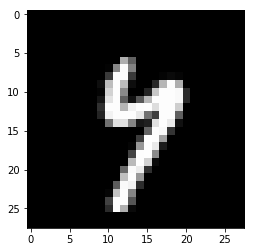

In [81]:
view_digit(data.train_x[4460], data.train_y[4460])
"""
4 is classified as 9 because 9 is written as circle with a line tangent to circle. While 4 can be written as cone and a line. 
That cone can be wriiten as curve if written in a hurry. Here 4 looks quite like 9.
"""

true label: 8


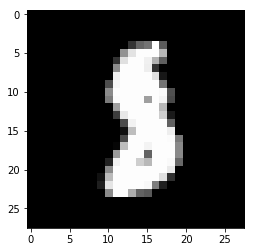

In [82]:
view_digit(data.train_x[3432], data.train_y[3432])
"""
here 8 is classified as 1 because the circles of 8 are not visible, they are almost filled up. It looks like thick vertical line
which indicates 1.
"""

true label: 7


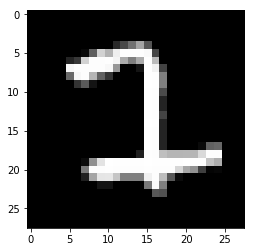

In [83]:
view_digit(data.train_x[2676], data.train_y[2676])
"""
Here 7 is classified as 1. 7 is wriiten as 7 and horizontal line in the middle. while 1 is written as 1 and horizontal line at 
the bottom. By mistake the horizontal line can be drawn at the bottom instead of in the middle. Hence, the misclassification.
"""